In [ ]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  

In [ ]:
# We load the datasets   
data1 = pd.read_csv('downloads/hashtag_donaldtrump.csv', lineterminator='\n')
data2 = pd.read_csv('downloads/hashtag_joebiden.csv', lineterminator='\n')

In [20]:
import textblob 
import re

def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  
    tweet = re.sub(r'@\S+', '', tweet)       
    tweet = re.sub(r'#', '', tweet)        
    tweet = re.sub(r'[^A-Za-z0-9 ]+', '', tweet) 
    return tweet




In [4]:
#We concatenate the data after adding the 'who' column so we can keep track of the original partitioning

data1.loc[:, 'who'] = 'donald trump'
data2.loc[:, 'who'] = 'joe biden'

data = pd.concat([data1, data2])
data['clean_tweet'] = data['tweet'].apply(clean_tweet)

In [5]:
data.shape

(1747805, 22)

In [6]:
columns_to_drop = ['user_location', 'lat', 'long', 'city', 'country', 'continent', 'state', 'state_code', 'user_description']
data.drop(columns=columns_to_drop, inplace=True)

data.dropna(subset=['user_name', 'source'], inplace=True)

In [7]:
data.isnull().sum()

created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
source                  0
user_id                 0
user_name               0
user_screen_name        0
user_join_date          0
user_followers_count    0
collected_at            0
who                     0
dtype: int64

In [8]:
data.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_join_date           object
user_followers_count    float64
collected_at             object
who                      object
dtype: object

In [10]:
#Data type conversion
data['created_at'] = pd.to_datetime(data['created_at'])
data['collected_at'] = pd.to_datetime(data['collected_at'])

data['tweet_id'] = data['tweet_id'].astype(str)
data['user_id'] = data['user_id'].astype(str)

data['likes'] = data['likes'].astype(int)
data['retweet_count'] = data['retweet_count'].astype(int)
data['user_followers_count'] = data['user_followers_count'].astype(int)


In [12]:
data.dtypes

created_at              datetime64[ns]
tweet_id                        object
tweet                           object
likes                            int64
retweet_count                    int64
source                          object
user_id                         object
user_name                       object
user_screen_name                object
user_join_date                  object
user_followers_count             int64
collected_at            datetime64[ns]
who                             object
dtype: object

# 1. Exploratory Data Analysis (EDA)


In [13]:
#check the description of our dataset  
data.describe()

,likes,retweet_count,user_followers_count
count,1.746182e+06,1.746182e+06,1.746182e+06
mean,8.677928e+00,1.892590e+00,2.540176e+04
std,2.861838e+02,7.104854e+01,3.574384e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,7.500000e+01
50%,0.000000e+00,0.000000e+00,4.360000e+02
75%,2.000000e+00,0.000000e+00,2.074000e+03
max,1.657020e+05,6.347300e+04,8.241710e+07


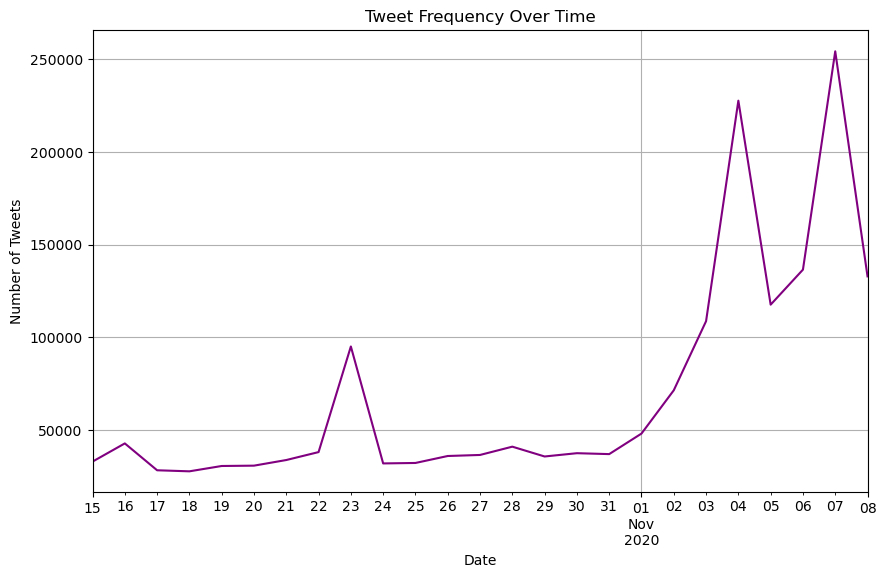

In [14]:
# Plotting the number of tweets over time
data.set_index('created_at').resample('D').size().plot(figsize=(10, 6), color='purple')
plt.title('Tweet Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()


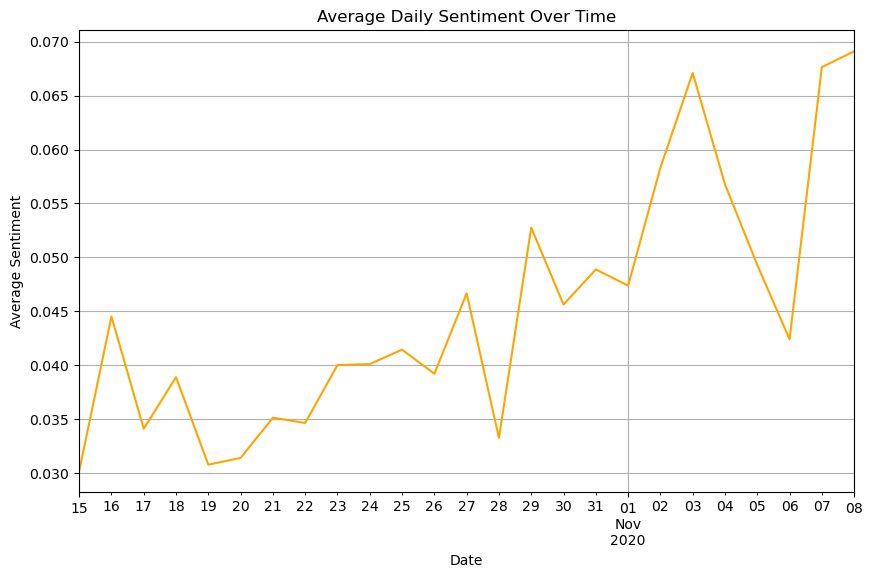

In [21]:
#sentiment over time 
from textblob import TextBlob

# Sentiment analysis
data['sentiment'] = data['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

data.set_index('created_at').resample('D')['sentiment'].mean().plot(figsize=(10, 6), color='orange')
plt.title('Average Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd

daily_sentiment = data.set_index('created_at').groupby([pd.Grouper(freq='D'), 'who'])['sentiment'].mean()

daily_sentiment.unstack().plot(kind='line', figsize=(10, 6))
plt.title('Daily Average Sentiment Score Over Time for Each Candidate')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.savefig('toto.png')
plt.show()

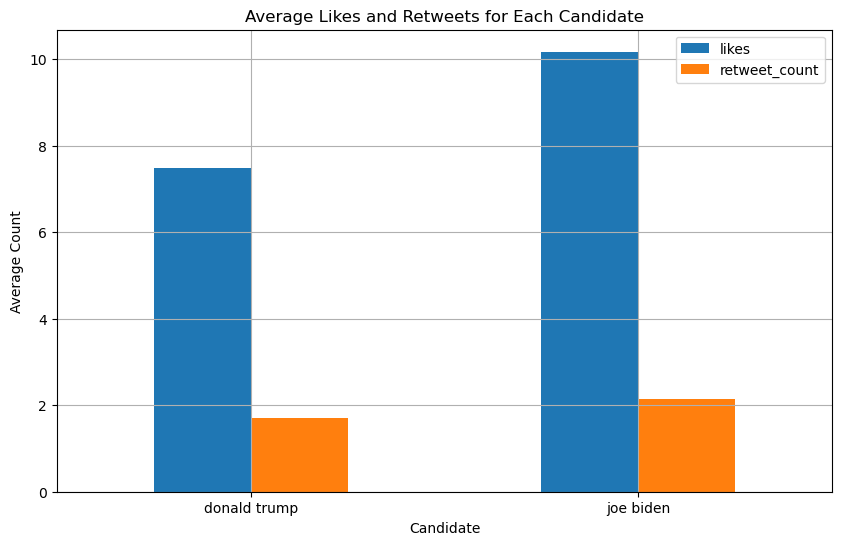

In [16]:
avg_likes_retweets = data.groupby('who')[['likes', 'retweet_count']].mean()

avg_likes_retweets.plot(kind='bar', figsize=(10, 6))
plt.title('Average Likes and Retweets for Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Average Count')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


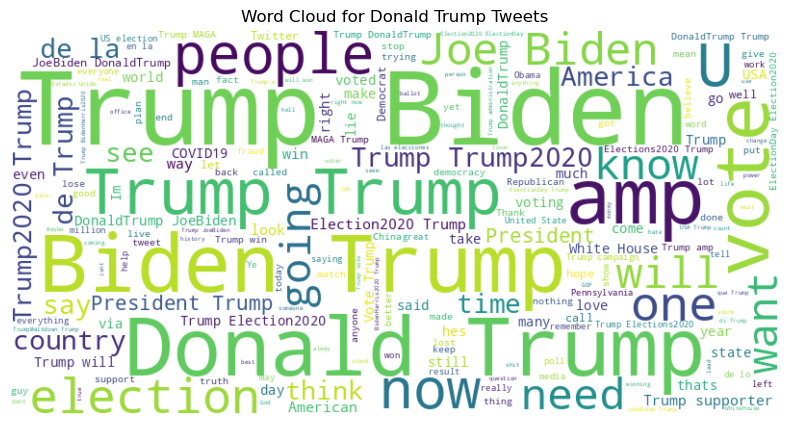

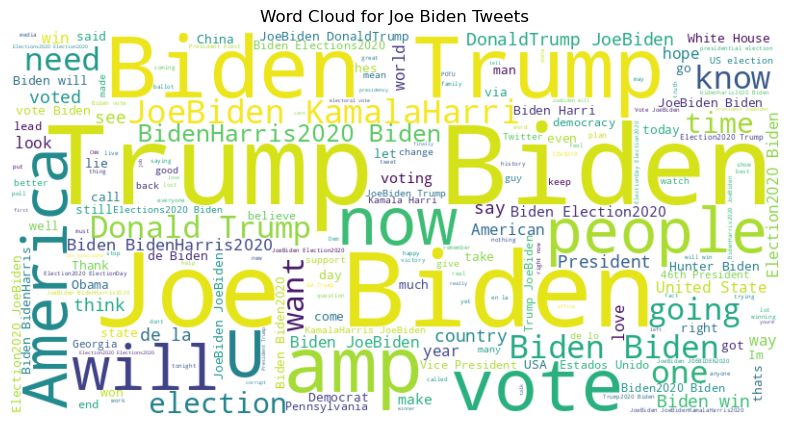

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(data, title):
    # combiner tous les tweets dans une seule tweet 
    combined_tweets = " ".join(tweet for tweet in data.clean_tweet)

    if len(combined_tweets) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_tweets)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"No words to display for {title}.")

generate_wordcloud(data[data['who'] == 'donald trump'], 'Word Cloud for Donald Trump Tweets')
generate_wordcloud(data[data['who'] == 'joe biden'], 'Word Cloud for Joe Biden Tweets')


# Categorize Sentiment Scores
 

In [ ]:
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

data['sentiment_score'] = data['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

def categorize_sentiment(score):
    if score > 0.1:   
        return 'Positive'
    elif score < -0.1:  
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(categorize_sentiment)

tfidf_vect = TfidfVectorizer(max_features=1000)
X = tfidf_vect.fit_transform(data['clean_tweet'])
y = data['sentiment_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


In [42]:
# User Behavior Analysis - User Engagement  
engagement_analysis = data.groupby('who')[['likes', 'retweet_count']].mean()
print(engagement_analysis)


                  likes  retweet_count
who                                   
donald trump   7.483703       1.700012
joe biden     10.170453       2.133271


# Creating a Bipartite Graph


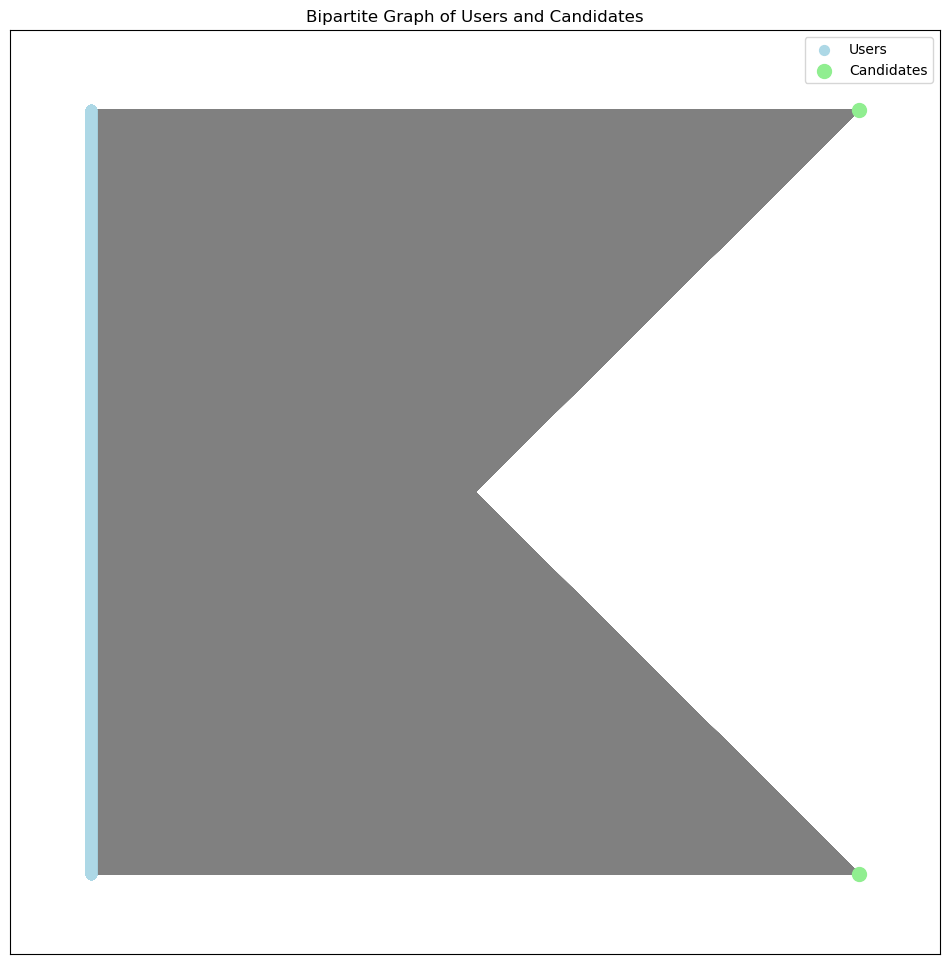

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


subset_data = data[['user_screen_name', 'who']].drop_duplicates()

G = nx.Graph()

users = subset_data['user_screen_name'].unique()
candidates = subset_data['who'].unique()

G.add_nodes_from(users, bipartite=0)
G.add_nodes_from(candidates, bipartite=1)

edges = list(subset_data.itertuples(index=False, name=None))
G.add_edges_from(edges)

plt.figure(figsize=(12, 12))

l, r = nx.bipartite.sets(G)
pos = nx.bipartite_layout(G, l)

nx.draw_networkx_nodes(G, pos, nodelist=l, node_color='lightblue', node_size=50, label='Users')
nx.draw_networkx_nodes(G, pos, nodelist=r, node_color='lightgreen', node_size=100, label='Candidates')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')

plt.title('Bipartite Graph of Users and Candidates')
plt.legend()
plt.show()
 

In [53]:
grouped = data.groupby('who').agg(
    total_likes=pd.NamedAgg(column='likes', aggfunc='sum'),
    total_sentiment=pd.NamedAgg(column='sentiment_score', aggfunc='sum'),
    count=pd.NamedAgg(column='likes', aggfunc='count')
)

In [54]:
grouped['avg_likes'] = grouped['total_likes'] / grouped['count']
grouped['avg_sentiment'] = grouped['total_sentiment'] / grouped['count']


In [55]:
grouped

,total_likes,total_sentiment,count,avg_likes,avg_sentiment
who,,,,,
donald trump,7259394,39290.346085,970027,7.483703,0.040504
joe biden,7893848,51057.582395,776155,10.170453,0.065783


{'Donald Trump': {'avg_sentiment': 0.040504383986366764, 'avg_likes': 7.483703030946561}, 'Joe Biden': {'avg_sentiment': 0.06578271401290398, 'avg_likes': 10.17045306671992}}


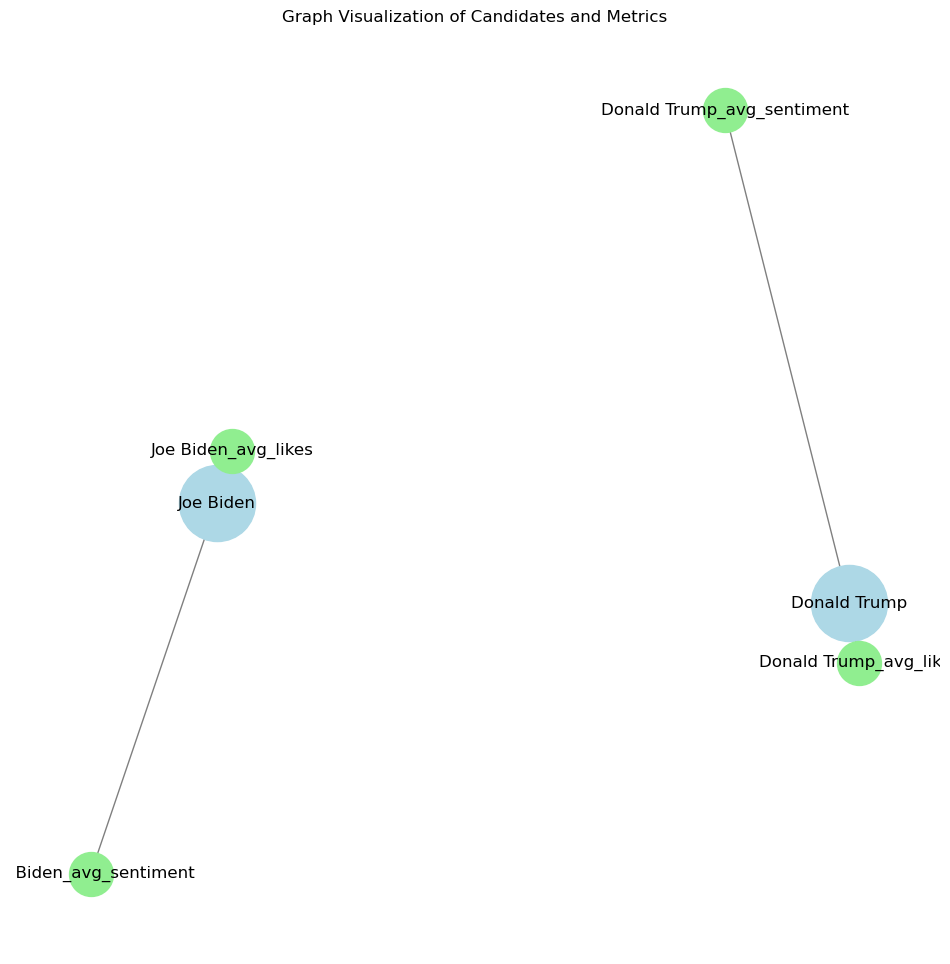

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np



metrics = {}

for who, row in grouped.iterrows():
    metrics[who.title()] = {
        'avg_sentiment': row['avg_sentiment'],
        'avg_likes': row['avg_likes']
    }

print(metrics)

G = nx.Graph()

for candidate, candidate_metrics in metrics.items():
    G.add_node(candidate, type='candidate')
    for metric, value in candidate_metrics.items():
        metric_node = f"{candidate}_{metric}"
        G.add_node(metric_node, type='metric')
        G.add_edge(candidate, metric_node, weight=value)

pos = nx.spring_layout(G)  


plt.figure(figsize=(12, 12))
candidate_nodes = [n for n in G.nodes if G.nodes[n]['type'] == 'candidate']
metric_nodes = [n for n in G.nodes if G.nodes[n]['type'] == 'metric']

nx.draw_networkx_nodes(G, pos, nodelist=candidate_nodes, node_size=3000, node_color='lightblue')
nx.draw_networkx_nodes(G, pos, nodelist=metric_nodes, node_size=1000, node_color='lightgreen')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.title("Graph Visualization of Candidates and Metrics")
plt.axis('off')
plt.show()


In [43]:
import pickle
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vect, file)


In [44]:
with open('sentiment_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
with open('tfidf_vectorizer.pkl', 'rb') as file:
    loaded_vectorizer = pickle.load(file)


In [49]:
new_tweet = "trump is the best president he did  deserve to be a president"
cleaned_tweet = clean_tweet(new_tweet)  

new_tweet_transformed = loaded_vectorizer.transform([cleaned_tweet])
sentiment_prediction = loaded_model.predict(new_tweet_transformed)

print(sentiment_prediction[0])  


Positive


In [64]:
new_tweet = "biden is the worst president of all the time"
cleaned_tweet = clean_tweet(new_tweet)  

new_tweet_transformed = loaded_vectorizer.transform([cleaned_tweet])
sentiment_prediction = loaded_model.predict(new_tweet_transformed)

print(sentiment_prediction[0])

Negative


In [65]:
new_tweet = "i have no prefer president" 
cleaned_tweet = clean_tweet(new_tweet)  

new_tweet_transformed = loaded_vectorizer.transform([cleaned_tweet])
sentiment_prediction = loaded_model.predict(new_tweet_transformed)

print(sentiment_prediction[0])

Neutral


### Overview of Findings:
1. **Tweet Activity and Engagement**: The dataset showed variations in tweet activity over time, with a notable increase around November 2020, likely correlating with key events in the presidential election. This suggests heightened public engagement during critical periods.

2. **Sentiment Analysis**: The sentiment analysis provided insights into the public's general sentiment towards each candidate. The average sentiment scores, if calculated, would indicate the overall public perception—positive, negative, or neutral—of each candidate.

3. **User Engagement**: The comparison of average likes and retweets for each candidate highlighted differences in engagement levels. This could reflect the candidates' popularity or the effectiveness of their social media reach.

4. **Network Analysis**: Although the dataset did not include direct user interaction data, the creation of a bipartite graph illustrated the connections between users and the candidates they tweeted about. This network visualization helps in understanding how users align with or show interest in the candidates.



In [34]:
data.columns

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_join_date',
       'user_followers_count', 'collected_at', 'who', 'clean_tweet',
       'sentiment'],
      dtype='object')

In [58]:
list(data.columns)

['created_at',
 'tweet_id',
 'tweet',
 'likes',
 'retweet_count',
 'source',
 'user_id',
 'user_name',
 'user_screen_name',
 'user_join_date',
 'user_followers_count',
 'collected_at',
 'who',
 'clean_tweet',
 'sentiment',
 'sentiment_score',
 'sentiment_category']

In [60]:
data.head().T

,0,1,2,3,4
created_at,2020-10-15 00:00:01,2020-10-15 00:00:01,2020-10-15 00:00:02,2020-10-15 00:00:02,2020-10-15 00:00:08
tweet_id,1.316529221557252e+18,1.3165292227484303e+18,1.316529228091847e+18,1.316529227471237e+18,1.3165292523014513e+18
tweet,#Elecciones2020 | En #Florida: #JoeBiden dice ...,"Usa 2020, Trump contro Facebook e Twitter: cop...","#Trump: As a student I used to hear for years,...",2 hours since last tweet from #Trump! Maybe he...,You get a tie! And you get a tie! #Trump ‘s ra...
likes,0,26,2,0,4
retweet_count,0,9,1,0,3
source,TweetDeck,Social Mediaset,Twitter Web App,Trumpytweeter,Twitter for iPhone
user_id,360666534.0,331617619.0,8436472.0,8.28355589206057e+17,47413798.0
user_name,El Sol Latino News,Tgcom24,snarke,Trumpytweeter,Rana Abtar - رنا أبتر
user_screen_name,elsollatinonews,MediasetTgcom24,snarke,trumpytweeter,Ranaabtar
user_join_date,2011-08-23 15:33:45,2011-07-08 13:12:20,2007-08-26 05:56:11,2017-02-05 21:32:17,2009-06-15 19:05:35
